# Detecting Deception in Enron Emails
## 3. K-Means Clustering

In this notebook, we attempt three methods of clustering and topic modeling, beginning with simple N-gram features, then reducing dimensionality for K-means using paragraph vectoring, or Doc2Vec. We also try variants of Latent Dirichlet Allocation (LDA) in the ensuing notebook to identify sub-topics within emails for comparison to our keyword-targeted labels.

### 3.0 Libraries and Preprocessed Data

Preprocessed data generated in prior workbook: https://github.com/colbycarter/NLP_Enron/blob/master/Enron_emails_PREPROCESSING.ipynb

In [1]:
from __future__ import print_function
from __future__ import division

import os, sys
import collections
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter
import time

import email
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy import sparse, hstack
from sklearn.feature_extraction.text import *
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
# run 'easy_install -U gensim' to install gensim and then re-launch jupyter notebook
import gensim
from sklearn.decomposition import PCA

# Helper libraries
import constants
import utils
import vocabulary

C:\Users\Colby\Anaconda3\lib\site-packages\gensim-3.4.0-py3.5-win-amd64.egg\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Preprocessed Dataset

In [2]:
# preprocessed import; runtime ~3 minutes for full set
# ENTER PATH FOR IMPORT AND EXPORT
path = 'C:/Users/Colby/Documents/Berkeley/266_NLP/final_project/data'
emails_df = pd.read_pickle(path + '/cleaned_emails.pkl')
emails_df.loc[228829, "suspicious_ind"] = 1
#print(sum(emails_df["suspicious_ind"]))
print(emails_df.shape)
emails_df.head()

(517401, 4)


,file,email_list,email_str,suspicious_ind
0,allen-p/_sent_mail/1.,"[here, is, our, forecast, <s>]",here is our forecast <s>,0.0
1,allen-p/_sent_mail/10.,"[traveling, to, have, a, business, meeting, ta...",traveling to have a business meeting takes the...,0.0
2,allen-p/_sent_mail/100.,"[test, successful, <s>, way, to, go, !, !, <s>...",test successful <s> way to go ! ! <s> ! <s>,0.0
3,allen-p/_sent_mail/1000.,"[randy, can, you, send, me, a, schedule, of, t...",randy can you send me a schedule of the salary...,0.0
4,allen-p/_sent_mail/1001.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",let 's shoot for tuesday at DGDG:DGDG <s>,0.0


### Functions for Evaluating Emails Nearest Labeled Examples

These functions assist both the simple baseline and paragraph vector implementations of K-means, icncluding generating predicted clusters for our full and labeled sets of emails.

In [3]:
def tfidf_fct(data, N_gram, max_df=.01, min_df=5):
    """Return tf-idf N-gram vectors"""
    transformer = TfidfTransformer()
    vectorize = CountVectorizer(ngram_range=(1, N_gram), max_df=max_df, min_df=min_df)
    n_grams = vectorize.fit_transform(data["email_str"])
    n_grams_idf = transformer.fit_transform(n_grams)
    print("N-grams TF-IDF:", n_grams_idf.shape)
    print(type(n_grams_idf))
    return n_grams_idf

def k_preds(data, feats, kmeans):
    """predict cluster of emails using an initialized k-means object"""
    base_preds = kmeans.predict(feats)
    print("Cluster counts:", Counter(base_preds))

    # GET IDS OF POSITIVE LABELS
    positive_labels = data[data["suspicious_ind"]==1]
    #print("pos labs:", positive_labels)
    labeled_ids = positive_labels.index.values

    print("Positive labels:\n", Counter(base_preds[data["suspicious_ind"]==1]))
    return base_preds, positive_labels, labeled_ids

def get_labels(data, features, preds, key_cluster, labeled_ids):
    """get feature set for the labeled examples in a cluster key_cluster"""
    # enter index of typical cluster
    ids = []
    for i in labeled_ids:
        if preds[i] == key_cluster:
            ids.append(i)
    print("Label IDs in selected cluster:\n", ids)
    cluster_ids = (preds==key_cluster).astype(int)
    labeled_feats = features[np.multiply(np.array(data["suspicious_ind"]), cluster_ids).astype(bool)]
    print("Labeled feature shape:", labeled_feats.shape)
    return labeled_feats

# cosine_similarity
def top_cos_sims(labeled_feats, features):
    """evaluate closest examples in example cluster based on cosine similarity"""
    cos_sims = cosine_similarity(labeled_feats, features)
    print("Cosign similarities shape:", cos_sims.shape)
    closest_args = np.argsort(cos_sims, axis = 1)[:,-12:-6]  #closest 6 examples, ignoring possible repeats
    print("Top 6 closest emails (IDs, right-to-left):\n", closest_args)
    print()
    print("Top 6 largest cos-sims in cluster:")
    for example in range(cos_sims.shape[0]):
        print(cos_sims[example, closest_args[example,:]])
        
# create tagged documents for paragraph vector training
def tag_docs(data):
    tagger = gensim.models.doc2vec.TaggedDocument
    tagged_docs = []
    for i, email in enumerate(data["email_list"]):
        tagged_docs.append(tagger(email, [i]))
    return tagged_docs

## 3.1 Baseline: K-Means Clustering with BOW Features

Using a random sample of only 50,000 emails to reduce dimensions in and run-time of baseline model.

In [3]:
# ENTER number of rows for training; NONE if using all
num_rows = 50000
use_full = False

if use_full == False:
    random.seed(24)
    rand_ids = random.sample(range(0, emails_df.shape[0]), num_rows)
    mini_df = emails_df.loc[rand_ids,]
    print("Mini shape:", mini_df.shape)

Mini shape: (50000, 4)


Turn emails into term-frequency and inverse-document-frequency weighted counts of limited unigram set, to keep feature set reasonable for fitting K-means.

In [66]:
n_grams_idf = tfidf_fct(mini_df, 1, .01, 5)

N-grams TF-IDF: (50000, 37082)
<class 'scipy.sparse.csr.csr_matrix'>


In [17]:
# fit k-means (n=4, tol=.01, max_iter=100 takes ~20 mins to train)
kmeans = KMeans(n_clusters=6, tol=.01, max_iter=30)
kmeans.fit(n_grams_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=30,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.01, verbose=0)

In [111]:
# evaluate predictions on positively labeled examples
base_preds, positive_labels, labeled_ids = k_preds(mini_df, n_grams_idf, kmeans)

Cluster counts: Counter({0: 48248, 1: 510, 2: 395, 4: 347, 3: 292, 5: 208})
Positive labels: Counter({0: 3})


Using simple unigram features leads to a very unbalanced K-means clustering, with over 96% of sampled examples falling in the same cluster, even after preprocessing and limiting length of emails. Because of this, we will want to generate stronger features with lower dimensionality that generalize better.

In [94]:
labeled_feats = get_labels(mini_df, n_grams_idf, base_preds, 0)
top_cos_sims(labeled_feats, n_grams_idf)

(3, 37082)
(3, 50000)
[[20023 30012 33765 24618 41249]
 [ 6763 34919  7488   142 10145]
 [26596  4460   561 11264 16541]]
[ 0.52720321  0.52720321  0.53289646  0.54345702  0.5770474 ]
[ 0.45147323  0.46390951  0.6663603   0.73649271  0.80389285]
[ 0.26537967  0.34106605  0.35264769  0.47085026  0.9844188 ]


In [80]:
# nearest emails flagged:
emails_df.loc[24618, "email_str"]

"can you coordinate the scott tholen 's team to do this asap ? <s> thanks <s> keep me updated on when fernley will have access <s> thanks <s> by sally beck/hou/ect on DGDG/DGDG/DGDGDGDG DGDG:DGDG pm - mark frevert enron DGDG/DGDG/DGDGDGDG DGDG:DGDG pm to : sally beck/hou/ect ect cc : subject : re : access to dpr for fernley dyson please go ahead and get fernley access to the dpr <s> thanks <s> mark <s>"

## 3.2 K-Means Clustering using Paragraph Vectors (doc2vec)

In order to reduce dimensions and get more balanced clusters, we train paragraph vectors using the full email dataset.

Gensim documentation: https://radimrehurek.com/gensim/models/doc2vec.html

Also see: https://stackoverflow.com/questions/41709318/what-is-gensims-docvecs

In [5]:
start = time.time()

#convert emails to tagged-documents
tagged_docs = tag_docs(emails_df)

#train doc2vec model
# 30 mins with full df, size = 1000 and window size of 5

#COMMENTED OUT AFTER FINAL RUN; RE-LOADED BELOW
#doc_model = gensim.models.doc2vec.Doc2Vec(documents=tagged_docs, vector_size = 2000, window = 5, alpha = .01, min_count = 5)

doc_model.save("doc_model")
doc_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

end = time.time()
print("Time to train doc2vec features:", end - start)

Time to train doc2vec features (sec): 0.0026673772301659612


In [4]:
#re-load model, if necessary
doc_model = gensim.models.doc2vec.Doc2Vec.load("doc_model")
doc_feats = doc_model.docvecs.vectors_docs
print(doc_feats.shape)
print(doc_model.docvecs.most_similar(0))

(517401, 2000)
[(501419, 0.9149469137191772), (513132, 0.9130669236183167), (502172, 0.9125531911849976), (515889, 0.9115132093429565), (500725, 0.9107814431190491), (465277, 0.9106547236442566), (490806, 0.9105073809623718), (5860, 0.9104685187339783), (517379, 0.9103668928146362), (501190, 0.9102362990379333)]


In [16]:
def train_kmeans(doc_feats, pca_vects, pca_labeled, num_clusters=4):
    """train and plot k-means, returning score for k selection to determine best-performing number of clusters"""
    start = time.time()
    
    kmeans_doc = KMeans(n_clusters=num_clusters, tol=.01, max_iter=30)
    preds = kmeans_doc.fit_predict(doc_feats)
    score = kmeans_doc.score(doc_feats)

    end = time.time()
    print("Time to train and score K-means:", (end - start)/60, "min")
    
    myColors = [str(round((i+.5)/num_clusters,2)) for i in range(0,num_clusters)]
    
    # plot clusters using 2d PCA
    
    plt.figure(figsize = (4, 4))

    for c in range(0,num_clusters):
        cluster = pca_vects[preds==c]
        plt.scatter(cluster[:,0], cluster[:,1], c = myColors[c], edgecolors = 'none')

    plt.scatter(pca_labeled[:,0], pca_labeled[:,1], c = "gold", marker="*")
    plt.title(str(num_clusters) + " Clusters from Paragraph Vectors")
    plt.show()
    
    return kmeans_doc, score

training 4 ...
Time to train and score K-means: 18.483506898085277 min


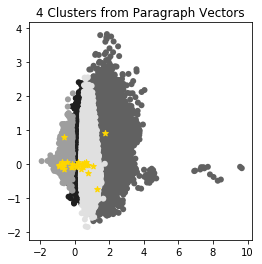

training 5 ...
Time to train and score K-means: 17.76042099793752 min


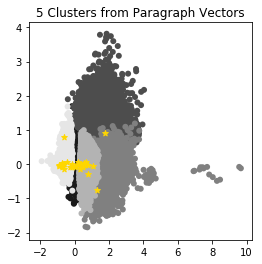

training 6 ...
Time to train and score K-means: 18.693909227848053 min


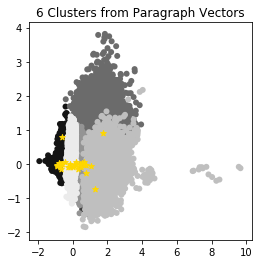

training 7 ...
Time to train and score K-means: 20.329534475008646 min


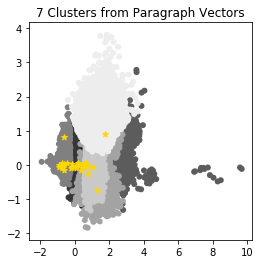

training 8 ...
Time to train and score K-means: 19.23298293352127 min


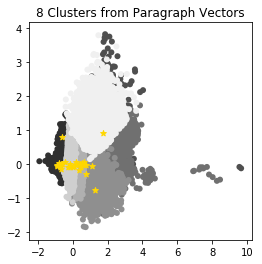

[-402893.17228085548, -392624.09188652784, -386400.14255584963, -380701.96570446901, -376556.84696698003]


In [17]:
# run and plot k-means using PCA=2 for visualizing
scores = []
k_s = range(4,9)

pca_model = PCA(n_components = 2)
pca_vects = pca_model.fit_transform(doc_feats)
positive_labels = emails_df[emails_df["suspicious_ind"]==1]
labeled_ids = positive_labels.index.values
pca_labeled = pca_model.fit_transform(pca_vects[labeled_ids])

for k in k_s:
    print("training", k, "...")
    kmeans_doc, score = train_kmeans(doc_feats, pca_vects, pca_labeled, k)
    scores.append(score)

print(scores)

2-dimensional plots of our vectorized emails show that the clustering effectiveness is limited, with K-means picking up features that suggest significant differences between examples.

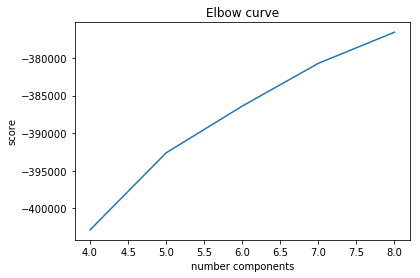

In [18]:
plt.plot(k_s, scores)
plt.xlabel('number components')
plt.ylabel('score')
plt.title("Elbow curve")
plt.show()

Each additional cluster only adds a marginal improvement to the K-means distance score, which also gives evidence that the clusters' features are not successfully capturing differences in deception. There also is still a significant imbalance in the cluster sizes.

In [23]:
preds, pos_labels, labeled_ids = k_preds(emails_df, doc_feats, kmeans_doc)

Cluster counts: Counter({1: 189694, 6: 148787, 5: 101060, 0: 51046, 3: 12528, 7: 6826, 4: 5312, 2: 2148})
Positive labels:
 Counter({0: 7, 1: 7, 5: 7, 6: 5, 4: 2, 3: 1, 7: 1})


We review a sample of nearest neighbors to the 7 labeled emails in cluster 1, excluding the five closest emails to avoid identifying redundant (pieces of) emails. Of those reviewed, five (or 15%) were newly discovered emails that would likely require scrutiny in a fraud or deceptive context:

In [25]:
labeled_feats = get_labels(emails_df, doc_feats, preds, 1, labeled_ids)
print()
top_cos_sims(labeled_feats, doc_feats)

Label IDs in selected cluster:
 [346, 373, 441, 908, 13966, 27091, 272962]
Labeled feature shape: (7, 2000)

Cosign similarities shape: (7, 517401)
Top 6 closest emails (IDs, right-to-left):
 [[366912 513996 461340 499861 264595 511116]
 [312740 487856 418827 480303   6176 371512]
 [ 80508 231933 157429  73639  64328   1701]
 [ 63463 228829 490916 231933    931   2684]
 [511177 507662 509210 452228 490315 510971]
 [ 17533  38183 103354 297044  39916  20569]
 [441352 441410  96898 444951   4982 364851]]

Top 6 largest cos-sims in cluster:
[ 0.82134473  0.8216998   0.82204467  0.82257271  0.82276487  0.82367671]
[ 0.65782952  0.65874618  0.66151214  0.66195118  0.66215014  0.66228801]
[ 0.61164916  0.61336386  0.61661243  0.64438927  0.66188645  0.66256636]
[ 0.54174334  0.54177338  0.54239058  0.56461418  0.59397316  0.63584793]
[ 0.7512908   0.75281316  0.75344026  0.75517952  0.75697309  0.75749117]
[ 0.38063788  0.38182178  0.38206846  0.38262337  0.3882415   0.52308619]
[ 0.60887343

In [73]:
# labeled example for comparison:
print("Labeled example:")
emails_df.loc[272962, "email_str"]

Labeled example:


'there will be news on this subject soon that could make the rockets payments to the city look very paltry without some good spin <s> since you did the enron deal i wanted to give you a heads up and some talking points which i will have for you monday <s> i think the news will keep until then <s>'

In [79]:
# for evaluation
print("Nearest neighbor example:")
emails_df.loc[364851, "email_str"]

Nearest neighbor example:


"if your team would like to contribute to this week 's newsletter please submit your business highlight or news by noon wednesday october DGDG. thank you ! <s> kathie grabstald x DG-DGDGDGDG <s>"

In [34]:
# Gold detected example:
print("Successful neighbor example:")
emails_df.loc[228829, "email_str"]

Successful neighbor example:


"what i meant by the term `` electric disconnect '' which i thought was catchy but may have been inartful was simply that supply and demand signals were screwed up <s> this is the `` shelly corman '' argument which may or may not have any factual basis but i put it in there to have it in front of people for discussion <s> steven j kean DGDG/DGDG/DGDGDGDG DGDG:DGDG pm to : jeff dasovich/na/enron enron cc : christi l nicolay/hou/ect ect james d steffes/na/enron enron janet r dietrich/hou/ect ect jeff dasovich/na/enron enron jeffrey t hodge/hou/ect ect joe hartsoe/corp/enron enron leslie lawner/na/enron enron mary hain/hou/ect ect maureen mcvicker/na/enron enron richard shapiro/na/enron enron shelley corman/et & s/enron enron subject : re : draft talking points about california gas market given the way the numbers came out i guess we do n't need the talking points but we should still try to get to the bottom of this because we will be called on to comment to regulators and media <s> unles